<a href="https://colab.research.google.com/github/prateekbeh/algo_ds/blob/master/seismic_lwe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import numpy as np
import pandas as pd
from netCDF4 import Dataset as dt
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.dates as mdt
import matplotlib.gridspec as gridspec
from matplotlib.colorbar import Colorbar
from datetime import datetime
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.animation as anim
from shapely.geometry import Point , shape , Polygon
from dataclasses import dataclass, fields
import matplotlib.pyplot as pl
import hvplot.xarray
#import fiona
import shapefile
import geopandas as gpd
import rasterio
from rasterio.features import geometry_mask
import netCDF4 as nc
import math
import pandas as pd
import plotly.graph_objects as go
import plotly.io as pio
from datetime import date
import geopandas as gpd
import numpy as np
from shapely.geometry import Polygon, MultiPolygon, Point

In [9]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 70.0 MB/s eta 0:00:00


In [ ]:
# Set the maximum number of rows and columns to display (None means no limit)
#pd.set_option('display.max_rows', None)   # Show all rows
#pd.set_option('display.max_columns', None)  # Show all columns


In [12]:
seismic_df = pd.read_csv('catalog.txt',delimiter = '\t')

FileNotFoundError: [Errno 2] No such file or directory: 'catalog.txt'

In [ ]:
lwe_df = xr.open_dataset("/Users/prateekb/Downloads/DL_doc/gsfc.glb_.200204_202403_rl06v2.0_obp-ice6gd_halfdegree.nc").lwe_thickness.to_dataframe().reset_index()

In [20]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

# Upload the catalog data file
uploaded = files.upload()

# Load the catalog data from the uploaded file
file_path = list(uploaded.keys())[0]
catalog_data = pd.read_csv(file_path, delim_whitespace=True)

# Step 1: Convert the date column to datetime format
catalog_data['date'] = pd.to_datetime(catalog_data['date'], format='%Y-%m-%d')

# Step 2: Divide the dataset into a grid of 0.5 x 0.5 degree
# Round the latitude and longitude to the nearest 0.5 to create 0.5 x 0.5 degree grids
catalog_data['lat_grid'] = (catalog_data['latitude'] // 0.5 * 0.5).round(1)
catalog_data['lon_grid'] = (catalog_data['longitude'] // 0.5 * 0.5).round(1)

# Step 3: Group by lat_grid, lon_grid, and date to get the sum of events per day
events_per_day = catalog_data.groupby(['lat_grid', 'lon_grid', 'date']).size().reset_index(name='event_count')

# Step 4: Sort the result by date
events_per_day = events_per_day.sort_values(by='date')

# Step 5: Filter data from 2020 to 2023 and get the minimum event count and corresponding dates
events_2020_2023 = events_per_day[(events_per_day['date'] >= '2020-01-01') & (events_per_day['date'] <= '2023-12-31')]
min_event_count = events_2020_2023['event_count'].min()
min_event_dates = events_2020_2023[events_2020_2023['event_count'] == min_event_count]

# Display the minimum event count and the corresponding dates
print(f"Minimum event count from 2020 to 2023: {min_event_count}")
print("Dates with minimum event count:")
print(min_event_dates[['date', 'event_count']])

# Display the result
events_per_day.head()


Saving catalog.txt to catalog (2).txt
Minimum event count from 2020 to 2023: 1
Dates with minimum event count:
            date  event_count
7278  2020-01-01            1
6780  2020-01-02            1
17534 2020-01-02            1
13757 2020-01-03            1
14515 2020-01-03            1
...          ...          ...
7282  2023-12-23            1
11446 2023-12-27            1
21900 2023-12-29            1
13794 2023-12-30            1
12140 2023-12-30            1

[1044 rows x 2 columns]


<ipython-input-20-d3bd9c46ce00>:12: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  catalog_data = pd.read_csv(file_path, delim_whitespace=True)


,lat_grid,lon_grid,date,event_count
2404,32.0,-116.0,1932-01-03,1
2405,32.0,-116.0,1932-01-07,1
1215,31.5,-116.0,1932-01-08,1
7128,33.5,-118.0,1932-01-10,1
7395,33.5,-117.0,1932-01-10,1


In [21]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

# Upload the catalog data file
uploaded = files.upload()

# Load the catalog data from the uploaded file
file_path = list(uploaded.keys())[0]
catalog_data = pd.read_csv(file_path, delim_whitespace=True)

# Step 1: Convert the date column to datetime format
catalog_data['date'] = pd.to_datetime(catalog_data['date'], format='%Y-%m-%d')

# Step 2: Divide the dataset into a grid of 0.5 x 0.5 degree
# Round the latitude and longitude to the nearest 0.5 to create 0.5 x 0.5 degree grids
catalog_data['lat_grid'] = (catalog_data['latitude'] // 0.5 * 0.5).round(1)
catalog_data['lon_grid'] = (catalog_data['longitude'] // 0.5 * 0.5).round(1)

# Step 3: Group by lat_grid, lon_grid, and date to get the sum of events per day
events_per_day = catalog_data.groupby(['lat_grid', 'lon_grid', 'date']).size().reset_index(name='event_count')

# Step 4: Sort the result by date
events_per_day = events_per_day.sort_values(by='date')

# Step 5: Filter data from 2020 to 2023 and get the minimum event count and corresponding dates
events_2020_2023 = events_per_day[(events_per_day['date'] >= '2020-01-01') & (events_per_day['date'] <= '2023-12-31')]
min_event_count = events_2020_2023['event_count'].min()
min_event_dates = events_2020_2023[events_2020_2023['event_count'] == min_event_count]

# Display the minimum event count and the corresponding dates
print(f"Minimum event count from 2020 to 2023: {min_event_count}")
print("Dates with minimum event count:")
print(min_event_dates[['date', 'lat_grid', 'lon_grid', 'event_count']])

# Display the result
events_per_day.head()


Saving catalog.txt to catalog (3).txt
Minimum event count from 2020 to 2023: 1
Dates with minimum event count:
            date  lat_grid  lon_grid  event_count
7278  2020-01-01      33.5    -118.0            1
6780  2020-01-02      33.5    -119.5            1
17534 2020-01-02      37.0    -122.0            1
13757 2020-01-03      35.5    -118.0            1
14515 2020-01-03      36.0    -121.0            1
...          ...       ...       ...          ...
7282  2023-12-23      33.5    -118.0            1
11446 2023-12-27      35.0    -121.0            1
21900 2023-12-29      38.5    -123.0            1
13794 2023-12-30      35.5    -118.0            1
12140 2023-12-30      35.0    -119.0            1

[1044 rows x 4 columns]


<ipython-input-21-7fe61837278d>:12: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  catalog_data = pd.read_csv(file_path, delim_whitespace=True)


,lat_grid,lon_grid,date,event_count
2404,32.0,-116.0,1932-01-03,1
2405,32.0,-116.0,1932-01-07,1
1215,31.5,-116.0,1932-01-08,1
7128,33.5,-118.0,1932-01-10,1
7395,33.5,-117.0,1932-01-10,1


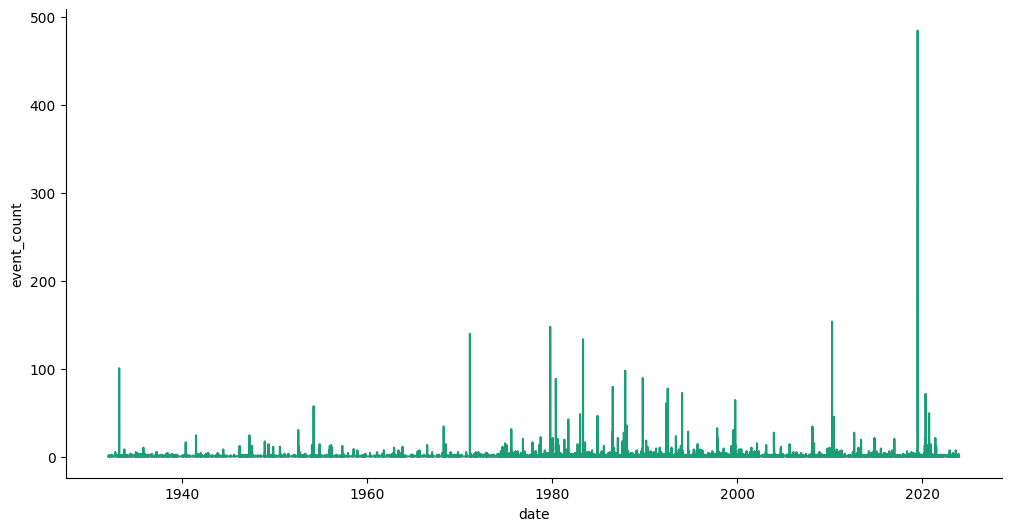

In [19]:
from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['date']
  ys = series['event_count']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = events_per_day.sort_values('date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('date')
_ = plt.ylabel('event_count')

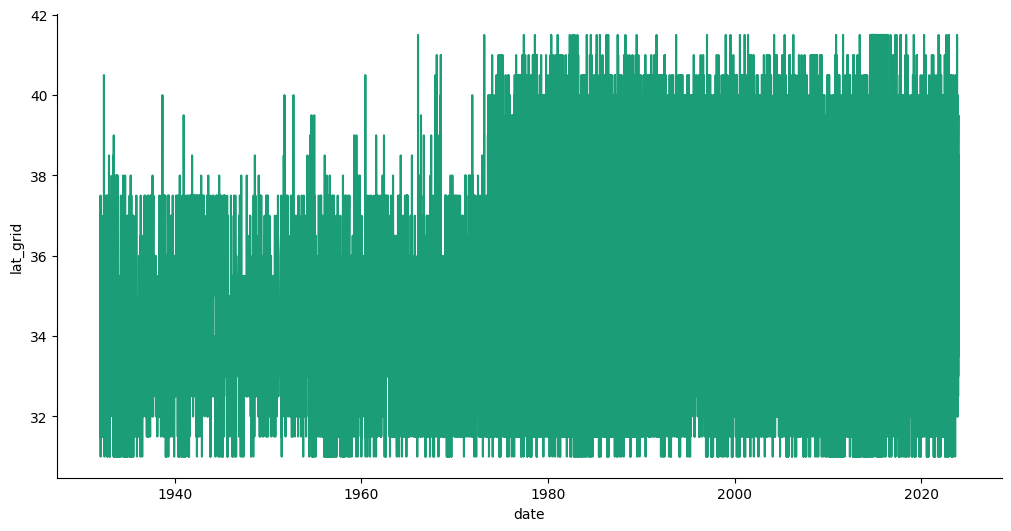

In [18]:
from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['date']
  ys = series['lat_grid']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = events_per_day.sort_values('date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('date')
_ = plt.ylabel('lat_grid')

In [23]:
# Display the lat and lon grid points for a specific date (e.g., 01-01-2020)
specific_date = '2020-01-01'
lat_lon_for_date = events_per_day[events_per_day['date'] == specific_date][['lat_grid', 'lon_grid', 'event_count']]
print(f"Lat and Lon grid points for {specific_date}:")
print(lat_lon_for_date)


Lat and Lon grid points for 2020-01-01:
      lat_grid  lon_grid  event_count
7278      33.5    -118.0            1


In [25]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

# Upload the catalog data file
uploaded = files.upload()

# Load the catalog data from the uploaded file
file_path = list(uploaded.keys())[0]
catalog_data = pd.read_csv(file_path, delim_whitespace=True)

# OLD CODE START

# OLD CODE END

# New Step 1: Convert the date column to datetime format
catalog_data['date'] = pd.to_datetime(catalog_data['date'], format='%Y-%m-%d')

# New Step 2: Divide the dataset into a grid of 0.5 x 0.5 degree
# Round the latitude and longitude to the nearest 0.5 to create 0.5 x 0.5 degree grids
catalog_data['lat_grid'] = (catalog_data['latitude'] // 0.5 * 0.5).round(1)
catalog_data['lon_grid'] = (catalog_data['longitude'] // 0.5 * 0.5).round(1)

# New Step 3: Group by lat_grid, lon_grid, and month to get the sum of events per month
catalog_data['year_month'] = catalog_data['date'].dt.to_period('M')
events_per_month = catalog_data.groupby(['lat_grid', 'lon_grid', 'year_month']).size().reset_index(name='event_count')

# New Step 4: Sort the result by year_month
events_per_month = events_per_month.sort_values(by='year_month')

# Display the result
events_per_month.head()


Saving catalog.txt to catalog (4).txt


<ipython-input-25-5b09d8e5cc12>:12: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  catalog_data = pd.read_csv(file_path, delim_whitespace=True)


,lat_grid,lon_grid,year_month,event_count
1650,32.0,-116.0,1932-01,2
11012,36.5,-118.5,1932-01,1
4925,33.5,-117.0,1932-01,1
870,31.5,-116.0,1932-01,2
7103,34.5,-121.0,1932-01,1


from matplotlib import pyplot as plt
_df_9['lat_grid'].plot(kind='hist', bins=20, title='lat_grid')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_10['lon_grid'].plot(kind='hist', bins=20, title='lon_grid')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_11['event_count'].plot(kind='hist', bins=20, title='event_count')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_12.plot(kind='scatter', x='lat_grid', y='lon_grid', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_13.plot(kind='scatter', x='lon_grid', y='event_count', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_14['lat_grid'].plot(kind='line', figsize=(8, 4), title='lat_grid')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_15['lon_grid'].plot(kind='line', figsize=(8, 4), title='lon_grid')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_16['event_count'].plot(kind='line', figsize=(8, 4), title='event_count')
plt.gca().spines[['top', 'right']].set_visible(False)

In [26]:
events_per_month

,lat_grid,lon_grid,year_month,event_count
1650,32.0,-116.0,1932-01,2
11012,36.5,-118.5,1932-01,1
4925,33.5,-117.0,1932-01,1
870,31.5,-116.0,1932-01,2
7103,34.5,-121.0,1932-01,1
...,...,...,...,...
14868,39.5,-120.0,2023-12,1
7024,34.0,-116.5,2023-12,2
10982,36.5,-121.0,2023-12,1
4824,33.5,-118.0,2023-12,2


In [29]:
# Step 5: Count the number of unique grid points for each month
unique_grid_points_per_month = events_per_month.groupby('year_month')[['lat_grid', 'lon_grid']].nunique().reset_index()
unique_grid_points_per_month = unique_grid_points_per_month.rename(columns={0: 'unique_grid_points_count'}) # Rename the column after reset_index

# Display the number of unique grid points for each month
print("Number of unique grid points for each month:")
print(unique_grid_points_per_month)

# Display the result
events_per_month.head()

Number of unique grid points for each month:
     year_month  lat_grid  lon_grid
0       1932-01         9         8
1       1932-02         7         9
2       1932-03         6         5
3       1932-04         7         6
4       1932-05         5         6
...         ...       ...       ...
1098    2023-08        12        14
1099    2023-09        10        11
1100    2023-10        12        12
1101    2023-11        10        10
1102    2023-12        10         7

[1103 rows x 3 columns]


,lat_grid,lon_grid,year_month,event_count
1650,32.0,-116.0,1932-01,2
11012,36.5,-118.5,1932-01,1
4925,33.5,-117.0,1932-01,1
870,31.5,-116.0,1932-01,2
7103,34.5,-121.0,1932-01,1


In [ ]:

seismic_df['datetime'] = pd.to_datetime(seismic_df['date'])


seismic_df['year_month'] = seismic_df['datetime'].dt.to_period('M')


monthly_seismic = seismic_df.groupby('year_month').agg({
    'mag': ['mean', 'max', 'sum', 'count'],  # Aggregate magnitudes
    # Add more metrics if needed
}).reset_index()


monthly_seismic.columns = ['year_month', 'mean_magnitude', 'max_magnitude', 'sum_magnitude', 'count_quakes']


In [ ]:
seismic_df = seismic_df.rename(columns={'latitude': 'lat', 'longitude': 'lon'})

In [ ]:
seismic_df['lat'] = seismic_df['lat'].apply(lambda x : round((x + 0.25) * 2) / 2 - 0.25)
seismic_df['lon'] = seismic_df['lon'].apply(lambda x : round((x + 0.25) * 2) / 2 - 0.25 + 360)

In [ ]:
# Step 1: Get unique lat and lon values from the seismic dataset
unique_lat_lon_seismic = seismic_df[['lat', 'lon']].drop_duplicates()

# Step 2: Filter the GRACE dataset based on lat and lon values present in the seismic dataset
filtered_lwe_df = pd.merge(lwe_df, unique_lat_lon_seismic, on=['lat', 'lon'], how='inner')

# Display the filtered GRACE dataset to verify
print(filtered_lwe_df.head())

        time    lat     lon  lwe_thickness   datetime year_month
0 2002-04-18  30.75  239.75      -1.672263 2002-04-18    2002-04
1 2002-04-18  30.75  242.75      -1.296487 2002-04-18    2002-04
2 2002-04-18  30.75  243.75      -1.153030 2002-04-18    2002-04
3 2002-04-18  30.75  244.75      -3.817514 2002-04-18    2002-04
4 2002-04-18  30.75  245.75      -0.838207 2002-04-18    2002-04


In [ ]:

filtered_lwe_df['datetime'] = pd.to_datetime(filtered_lwe_df['time'])


filtered_lwe_df['year_month'] = filtered_lwe_df['datetime'].dt.to_period('M')


monthly_lwe = filtered_lwe_df.groupby('year_month').agg({
    'lwe_thickness': ['mean', 'max', 'sum', 'count'],  # Aggregate magnitudes
    # Add more metrics if needed
}).reset_index()


monthly_lwe.columns = ['year_month', 'mean_lwe', 'max_lwe', 'sum_lwe', 'count_lwe']


In [ ]:
monthly_lwe

,year_month,mean_lwe,max_lwe,sum_lwe,count_lwe
0,2002-04,6.206626,21.010732,2339.898075,377
1,2002-05,3.209977,11.453189,1210.161274,377
2,2002-08,-2.215539,3.270855,-835.258368,377
3,2002-09,-4.491712,6.245145,-1693.375517,377
4,2002-10,-5.515624,1.549472,-2079.390263,377
...,...,...,...,...,...
225,2023-11,-19.557842,5.690317,-7373.306536,377
226,2023-12,-17.374573,5.458380,-6550.214131,377
227,2024-01,-9.870144,14.994248,-3721.044150,377
228,2024-02,-6.225377,17.175660,-2346.967269,377


In [ ]:
available_year_months_in_lwe = lwe_df['year_month'].unique()

# Step 3: Filter the seismic DataFrame based on 'year_month' available in the GRACE LWE dataset
monthly_seismic = monthly_seismic[monthly_seismic['year_month'].isin(available_year_months_in_lwe)]

In [ ]:
monthly_seismic

,year_month,mean_magnitude,max_magnitude,sum_magnitude,count_quakes
842,2002-04,3.415882,4.39,58.07,17
843,2002-05,3.438049,4.90,140.96,41
846,2002-08,3.206364,3.75,35.27,11
847,2002-09,3.510000,4.78,94.77,27
848,2002-10,3.394762,4.77,71.29,21
...,...,...,...,...,...
1098,2023-08,3.417027,5.08,126.43,37
1099,2023-09,3.512381,4.99,73.76,21
1100,2023-10,3.533810,4.24,74.21,21
1101,2023-11,3.502308,4.30,45.53,13


In [ ]:
available_year_months_in_seismic_data = monthly_seismic['year_month'].unique()

# Step 3: Filter the seismic DataFrame based on 'year_month' available in the GRACE LWE dataset
monthly_lwe = monthly_lwe[monthly_lwe['year_month'].isin(available_year_months_in_seismic_data)]

In [ ]:
monthly_lwe

,year_month,mean_magnitude,max_magnitude,sum_magnitude,count_quakes
842,2002-04,3.415882,4.39,58.07,17
843,2002-05,3.438049,4.90,140.96,41
846,2002-08,3.206364,3.75,35.27,11
847,2002-09,3.510000,4.78,94.77,27
848,2002-10,3.394762,4.77,71.29,21
...,...,...,...,...,...
1098,2023-08,3.417027,5.08,126.43,37
1099,2023-09,3.512381,4.99,73.76,21
1100,2023-10,3.533810,4.24,74.21,21
1101,2023-11,3.502308,4.30,45.53,13


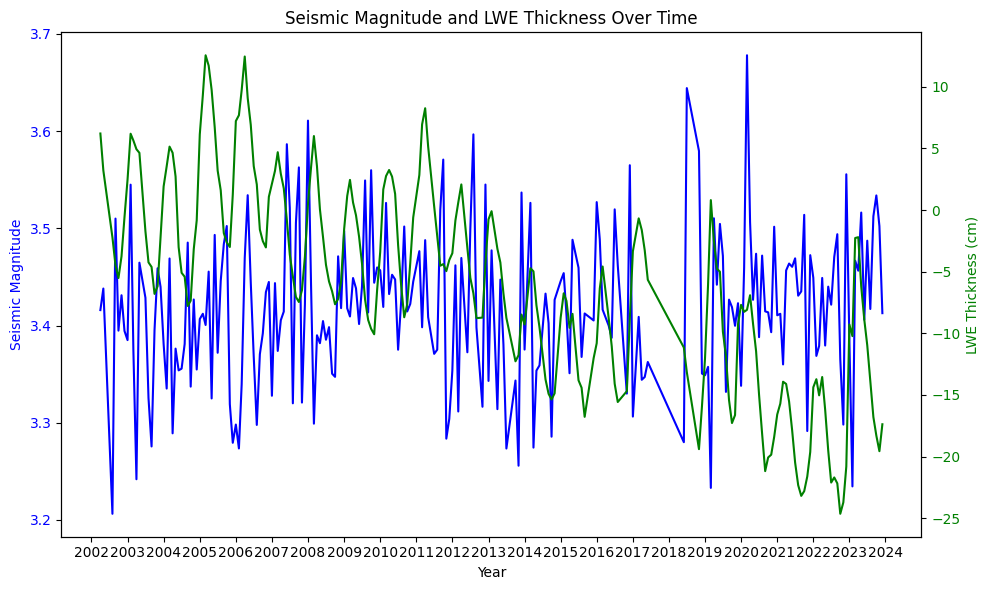

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Assuming 'monthly_lwe' and 'monthly_seismic' are your DataFrames
# Merge the two DataFrames on 'year_month' for consistent plotting
merged_data = pd.merge(monthly_lwe, monthly_seismic, on='year_month', how='inner')

# Convert 'year_month' to datetime for easier formatting (if needed)
merged_data['year_month_dt'] = merged_data['year_month'].dt.to_timestamp()

# Create a plot with a secondary y-axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot seismic magnitude (on primary y-axis)
ax1.plot(merged_data['year_month_dt'], merged_data['mean_magnitude'], color='b', label='Seismic Magnitude (Richter Scale)')
ax1.set_xlabel('Year')
ax1.set_ylabel('Seismic Magnitude', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Create a secondary y-axis for LWE thickness
ax2 = ax1.twinx()
ax2.plot(merged_data['year_month_dt'], merged_data['mean_lwe'], color='g', label='LWE Thickness (cm)')
ax2.set_ylabel('LWE Thickness (cm)', color='g')
ax2.tick_params(axis='y', labelcolor='g')

# Format the x-axis to show only the year
ax1.xaxis.set_major_locator(mdates.YearLocator())  # Set major ticks to be yearly
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format the ticks to show the year

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add a title and show the plot
plt.title('Seismic Magnitude and LWE Thickness Over Time')

plt.tight_layout()
plt.show()


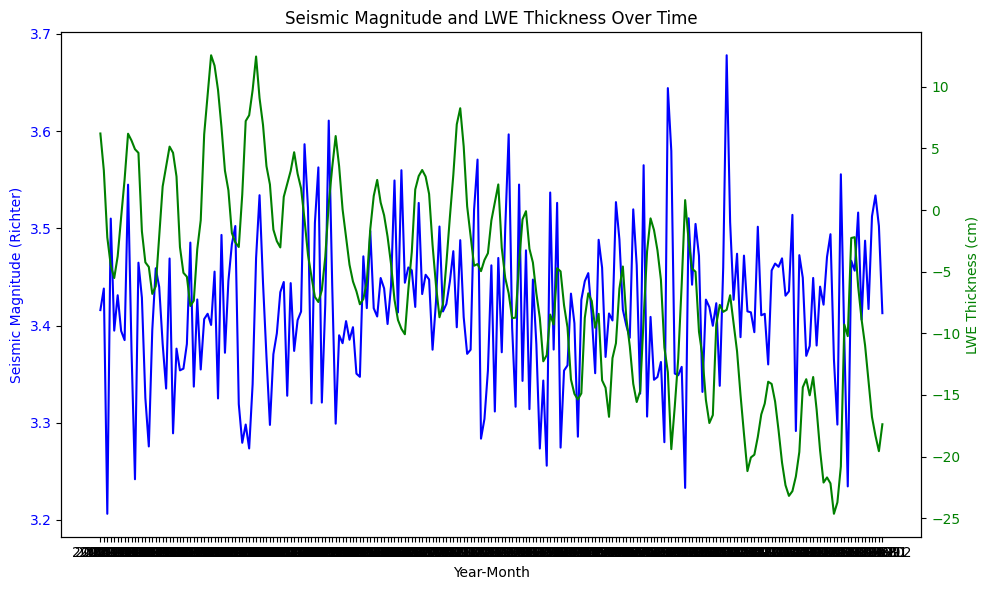

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'monthly_lwe' and 'monthly_seismic' are your DataFrames

# Merge the two DataFrames on 'year_month' for consistent plotting
merged_data = pd.merge(monthly_lwe, monthly_seismic, on='year_month', how='inner')

# Convert 'year_month' to string format for plotting
merged_data['year_month_str'] = merged_data['year_month'].astype(str)

# Create a plot with a secondary y-axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot seismic magnitude (on primary y-axis)
ax1.plot(merged_data['year_month_str'], merged_data['mean_magnitude'], color='b', label='Seismic Magnitude (Richter Scale)')
ax1.set_xlabel('Year-Month')
ax1.set_ylabel('Seismic Magnitude (Richter)', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Create a secondary y-axis for LWE thickness
ax2 = ax1.twinx()
ax2.plot(merged_data['year_month_str'], merged_data['mean_lwe'], color='g', label='LWE Thickness (cm)')
ax2.set_ylabel('LWE Thickness (cm)', color='g')
ax2.tick_params(axis='y', labelcolor='g')

# Add a title and show the plot
plt.title('Seismic Magnitude and LWE Thickness Over Time')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Display the plot
plt.tight_layout()
plt.show()


In [ ]:
merged_data

,year_month,mean_lwe,max_lwe,sum_lwe,count_lwe,mean_magnitude,max_magnitude,sum_magnitude,count_quakes,year_month_str
0,2002-04,6.206626,21.010732,2339.898075,377,3.415882,4.39,58.07,17,2002-04
1,2002-05,3.209977,11.453189,1210.161274,377,3.438049,4.90,140.96,41,2002-05
2,2002-08,-2.215539,3.270855,-835.258368,377,3.206364,3.75,35.27,11,2002-08
3,2002-09,-4.491712,6.245145,-1693.375517,377,3.510000,4.78,94.77,27,2002-09
4,2002-10,-5.515624,1.549472,-2079.390263,377,3.394762,4.77,71.29,21,2002-10
...,...,...,...,...,...,...,...,...,...,...
222,2023-08,-13.891592,6.391975,-5237.130131,377,3.417027,5.08,126.43,37,2023-08
223,2023-09,-16.790739,7.058719,-6330.108466,377,3.512381,4.99,73.76,21,2023-09
224,2023-10,-18.296908,5.172317,-6897.934349,377,3.533810,4.24,74.21,21,2023-10
225,2023-11,-19.557842,5.690317,-7373.306536,377,3.502308,4.30,45.53,13,2023-11


In [ ]:
correlation = merged_data[['mean_lwe', 'mean_magnitude']].corr()


In [ ]:
correlation

,mean_lwe,mean_magnitude
mean_lwe,1.000000,-0.112557
mean_magnitude,-0.112557,1.000000


In [ ]:
lwe_df['datetime'] = pd.to_datetime(lwe_df['time'])
seismic_df['datetime'] = pd.to_datetime(seismic_df['date'])

lwe_df['year_month'] = lwe_df['datetime'].dt.to_period('M')  # GRACE LWE dataset
seismic_df['year_month'] = seismic_df['datetime'].dt.to_period('M')  # Seismic dataset

In [ ]:
common_year_months = pd.Series(list(set(lwe_df['year_month']).intersection(set(seismic_df['year_month']))))


filtered_lwe_df_t = lwe_df[lwe_df['year_month'].isin(common_year_months)]
filtered_seismic_df_t = seismic_df[seismic_df['year_month'].isin(common_year_months)]

print(filtered_lwe_df.head())
print(filtered_seismic_df.head())


        time    lat   lon  lwe_thickness year_month   datetime
0 2002-04-18 -89.75  0.25     -10.319427    2002-04 2002-04-18
1 2002-04-18 -89.75  0.75     -10.306927    2002-04 2002-04-18
2 2002-04-18 -89.75  1.25     -10.294414    2002-04 2002-04-18
3 2002-04-18 -89.75  1.75     -10.281900    2002-04 2002-04-18
4 2002-04-18 -89.75  2.25     -10.269387    2002-04 2002-04-18
             date           time   latitude   longitude  depth   mag magtype  \
27254  2002-04-01  06:47:37.930Z  38.784667 -122.758667  2.071  3.13      md   
27255  2002-04-05  08:02:56.050Z  34.524000 -116.294667  4.548  4.39      ml   
27256  2002-04-07  06:01:26.560Z  38.822500 -122.798000  3.420  3.32      ml   
27257  2002-04-07  13:58:43.480Z  32.105167 -115.455667  6.961  3.30      ml   
27258  2002-04-07  23:32:22.970Z  31.821167 -116.223333  0.482  3.16      ml   

        datetime year_month  
27254 2002-04-01    2002-04  
27255 2002-04-05    2002-04  
27256 2002-04-07    2002-04  
27257 2002-04-07    2

In [ ]:
filtered_seismic_df_t['latitude'] = filtered_seismic_df_t['latitude'].apply(lambda x : round((x + 0.25) * 2) / 2 - 0.25)
filtered_seismic_df_t['longitude'] = filtered_seismic_df_t['longitude'].apply(lambda x : round((x + 0.25) * 2) / 2 - 0.25 + 360)

/var/folders/my/fm_4jwz90fqcy51vn6sdpl2r0000gn/T/ipykernel_11330/1691125249.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_seismic_df_t['latitude'] = filtered_seismic_df_t['latitude'].apply(lambda x : round((x + 0.25) * 2) / 2 - 0.25)
/var/folders/my/fm_4jwz90fqcy51vn6sdpl2r0000gn/T/ipykernel_11330/1691125249.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_seismic_df_t['longitude'] = filtered_seismic_df_t['longitude'].apply(lambda x : round((x + 0.25) * 2) / 2 - 0.25 + 360)


In [ ]:
filtered_seismic_df_t

,date,time,latitude,longitude,depth,mag,magtype,datetime,year_month
27254,2002-04-01,06:47:37.930Z,38.75,237.25,2.071,3.13,md,2002-04-01,2002-04
27255,2002-04-05,08:02:56.050Z,34.75,243.75,4.548,4.39,ml,2002-04-05,2002-04
27256,2002-04-07,06:01:26.560Z,38.75,237.25,3.420,3.32,ml,2002-04-07,2002-04
27257,2002-04-07,13:58:43.480Z,32.25,244.75,6.961,3.30,ml,2002-04-07,2002-04
27258,2002-04-07,23:32:22.970Z,31.75,243.75,0.482,3.16,ml,2002-04-07,2002-04
...,...,...,...,...,...,...,...,...,...
37786,2023-12-27,17:25:29.430Z,35.75,242.25,2.570,3.32,ml,2023-12-27,2023-12
37787,2023-12-27,20:05:40.510Z,35.25,239.25,6.220,3.07,ml,2023-12-27,2023-12
37788,2023-12-29,07:10:11.880Z,38.75,237.25,2.080,3.41,ml,2023-12-29,2023-12
37789,2023-12-30,02:26:27.530Z,35.25,241.25,5.210,3.52,ml,2023-12-30,2023-12


In [ ]:
filtered_seismic_df_t = filtered_seismic_df_t.rename(columns={'latitude': 'lat', 'longitude': 'lon'})

In [ ]:
filtered_seismic_df_t

,date,time,lat,lon,depth,mag,magtype,datetime,year_month
27254,2002-04-01,06:47:37.930Z,38.75,237.25,2.071,3.13,md,2002-04-01,2002-04
27255,2002-04-05,08:02:56.050Z,34.75,243.75,4.548,4.39,ml,2002-04-05,2002-04
27256,2002-04-07,06:01:26.560Z,38.75,237.25,3.420,3.32,ml,2002-04-07,2002-04
27257,2002-04-07,13:58:43.480Z,32.25,244.75,6.961,3.30,ml,2002-04-07,2002-04
27258,2002-04-07,23:32:22.970Z,31.75,243.75,0.482,3.16,ml,2002-04-07,2002-04
...,...,...,...,...,...,...,...,...,...
37786,2023-12-27,17:25:29.430Z,35.75,242.25,2.570,3.32,ml,2023-12-27,2023-12
37787,2023-12-27,20:05:40.510Z,35.25,239.25,6.220,3.07,ml,2023-12-27,2023-12
37788,2023-12-29,07:10:11.880Z,38.75,237.25,2.080,3.41,ml,2023-12-29,2023-12
37789,2023-12-30,02:26:27.530Z,35.25,241.25,5.210,3.52,ml,2023-12-30,2023-12


In [ ]:
unique_lat_lon_seismic = filtered_seismic_df_t[['lat', 'lon']].drop_duplicates()

filtered_lwe_df_t_la_lo = pd.merge(filtered_lwe_df_t, unique_lat_lon_seismic, on=['lat', 'lon'], how='inner')

print(filtered_lwe_df_t_la_lo.head())

NameError: name 'filtered_seismic_df_t' is not defined

In [ ]:
filtered_lwe_df_t_la_lo = filtered_lwe_df_t_la_lo.drop_duplicates()

In [ ]:
filtered_seismic_df_t[['lat', 'lon']].drop_duplicates()

,lat,lon
27254,38.75,237.25
27255,34.75,243.75
27257,32.25,244.75
27258,31.75,243.75
27261,37.75,241.25
...,...,...
37379,39.25,238.75
37446,31.75,241.75
37465,39.25,242.75
37598,39.25,243.75


In [ ]:
seismic_df

,date,time,latitude,longitude,depth,mag,magtype,year_month
27255,2002-04-05,08:02:56.050Z,34.75,243.75,4.548,4.39,ml,2002-04
27256,2002-04-07,06:01:26.560Z,38.75,237.25,3.420,3.32,ml,2002-04
27257,2002-04-07,13:58:43.480Z,32.25,244.75,6.961,3.30,ml,2002-04
27258,2002-04-07,23:32:22.970Z,31.75,243.75,0.482,3.16,ml,2002-04
27259,2002-04-09,17:15:03.700Z,32.25,244.75,6.968,3.01,ml,2002-04
...,...,...,...,...,...,...,...,...
37786,2023-12-27,17:25:29.430Z,35.75,242.25,2.570,3.32,ml,2023-12
37787,2023-12-27,20:05:40.510Z,35.25,239.25,6.220,3.07,ml,2023-12
37788,2023-12-29,07:10:11.880Z,38.75,237.25,2.080,3.41,ml,2023-12
37789,2023-12-30,02:26:27.530Z,35.25,241.25,5.210,3.52,ml,2023-12


In [ ]:
seismic_df = seismic_df.rename(columns={'latitude': 'lat', 'longitude': 'lon'})

In [ ]:
# Ensure both DataFrames (seismic_df and lwe_df) have consistent column names for 'lat' and 'lon'
unique_lat_lon_seismic = seismic_df[['lat', 'lon']].drop_duplicates()

# Merge lwe_df and unique_lat_lon_seismic on lat and lon
filtered_lwe_df = pd.merge(lwe_df, unique_lat_lon_seismic, on=['lat', 'lon'], how='inner')

# Display the filtered GRACE data
print(filtered_lwe_df.head())

        time    lat     lon  lwe_thickness
0 2002-04-18  31.25  240.25      -1.672263
1 2002-04-18  31.25  240.75      -1.672263
2 2002-04-18  31.25  243.25      -1.161658
3 2002-04-18  31.25  243.75      -2.261868
4 2002-04-18  31.25  244.25      -0.909215


In [ ]:
filtered_lwe_df

,time,lat,lon,lwe_thickness
0,2002-04-18,31.25,240.25,-1.672263
1,2002-04-18,31.25,240.75,-1.672263
2,2002-04-18,31.25,243.25,-1.161658
3,2002-04-18,31.25,243.75,-2.261868
4,2002-04-18,31.25,244.25,-0.909215
...,...,...,...,...
64213,2024-03-17,41.75,239.75,-5.763919
64214,2024-03-17,41.75,240.25,-6.189666
64215,2024-03-17,41.75,241.25,-6.617385
64216,2024-03-17,41.75,242.75,-6.220292


In [ ]:
# Create a plot with a secondary y-axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot seismic magnitude (on primary y-axis)
ax1.plot(matched_data['datetime'], matched_data['magnitude'], color='b', label='Seismic Magnitude (Richter Scale)')
ax1.set_xlabel('Date')
ax1.set_ylabel('Seismic Magnitude (Richter)', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Create a secondary y-axis for LWE thickness
ax2 = ax1.twinx()
ax2.plot(matched_data['datetime'], matched_data['LWE_thickness'], color='g', label='LWE Thickness (cm)')
ax2.set_ylabel('LWE Thickness (cm)', color='g')
ax2.tick_params(axis='y', labelcolor='g')

# Add a title and show the plot
plt.title('Seismic Magnitude and LWE Thickness Over Time')

# Display the plot
plt.show()

,lat,lon
0,-89.75,0.25
1,-89.75,0.75
2,-89.75,1.25
3,-89.75,1.75
4,-89.75,2.25
...,...,...
259195,89.75,357.75
259196,89.75,358.25
259197,89.75,358.75
259198,89.75,359.25


In [ ]:
filtered_df = lwe_df.loc[(lwe_df['lat'] == 34.75 ) & (lwe_df['lon'] == 243.75)]

In [ ]:
seismic_df

,date,time,lat,lon,depth,mag,magtype,year_month
27255,2002-04-05,08:02:56.050Z,34.75,243.75,4.548,4.39,ml,2002-04
27256,2002-04-07,06:01:26.560Z,38.75,237.25,3.420,3.32,ml,2002-04
27257,2002-04-07,13:58:43.480Z,32.25,244.75,6.961,3.30,ml,2002-04
27258,2002-04-07,23:32:22.970Z,31.75,243.75,0.482,3.16,ml,2002-04
27259,2002-04-09,17:15:03.700Z,32.25,244.75,6.968,3.01,ml,2002-04
...,...,...,...,...,...,...,...,...
37786,2023-12-27,17:25:29.430Z,35.75,242.25,2.570,3.32,ml,2023-12
37787,2023-12-27,20:05:40.510Z,35.25,239.25,6.220,3.07,ml,2023-12
37788,2023-12-29,07:10:11.880Z,38.75,237.25,2.080,3.41,ml,2023-12
37789,2023-12-30,02:26:27.530Z,35.25,241.25,5.210,3.52,ml,2023-12


In [ ]:



lwe_df['datetime'] = pd.to_datetime(lwe_df['time'])
seismic_df['datetime'] = pd.to_datetime(seismic_df['date'])

lwe_df['year_month'] = lwe_df['datetime'].dt.to_period('M')  # GRACE LWE dataset
seismic_df['year_month'] = seismic_df['datetime'].dt.to_period('M')  # Seismic dataset



In [ ]:
# Step 2: Find common 'year_month' values between the two datasets
common_year_months = pd.Series(list(set(lwe_df['year_month']).intersection(set(seismic_df['year_month']))))



In [ ]:
seismic_df = seismic_df.rename(columns={'latitude': 'lat', 'longitude': 'lon'})


In [ ]:
# Filter both datasets based on common 'year_month' values
filtered_lwe_df = lwe_df[lwe_df['year_month'].isin(common_year_months)]
filtered_seismic_df = seismic_df[seismic_df['year_month'].isin(common_year_months)]



In [ ]:
# Step 3: Get unique lat/lon pairs from the seismic dataset
unique_lat_lon_seismic = filtered_seismic_df[['lat', 'lon']].drop_duplicates()



In [ ]:
# Step 4: Filter GRACE data to match lat/lon from seismic data
filtered_lwe_df = pd.merge(filtered_lwe_df, unique_lat_lon_seismic, on=['lat', 'lon'], how='inner')





In [ ]:
# Step 5: Merge the two datasets on 'year_month', 'lat', and 'lon'
matched_data = pd.merge(filtered_lwe_df, filtered_seismic_df, on=['year_month', 'lat', 'lon'], how='inner')



In [ ]:
# Display the matched data
print(matched_data.head())

In [ ]:
filtered_seismic_df

,date,time,latitude,longitude,depth,mag,magtype,datetime,year_month
27254,2002-04-01,06:47:37.930Z,38.784667,-122.758667,2.071,3.13,md,2002-04-01,2002-04
27255,2002-04-05,08:02:56.050Z,34.524000,-116.294667,4.548,4.39,ml,2002-04-05,2002-04
27256,2002-04-07,06:01:26.560Z,38.822500,-122.798000,3.420,3.32,ml,2002-04-07,2002-04
27257,2002-04-07,13:58:43.480Z,32.105167,-115.455667,6.961,3.30,ml,2002-04-07,2002-04
27258,2002-04-07,23:32:22.970Z,31.821167,-116.223333,0.482,3.16,ml,2002-04-07,2002-04
...,...,...,...,...,...,...,...,...,...
37786,2023-12-27,17:25:29.430Z,35.925333,-117.684000,2.570,3.32,ml,2023-12-27,2023-12
37787,2023-12-27,20:05:40.510Z,35.235500,-120.784000,6.220,3.07,ml,2023-12-27,2023-12
37788,2023-12-29,07:10:11.880Z,38.814000,-122.798833,2.080,3.41,ml,2023-12-29,2023-12
37789,2023-12-30,02:26:27.530Z,35.400333,-118.645167,5.210,3.52,ml,2023-12-30,2023-12


In [ ]:
seismic_df

,date,time,latitude,longitude,depth,mag,magtype,datetime,year_month
0,1932-01-03,17:58:10.010Z,32.000000,-116.000000,6.00,3.00,mh,1932-01-03,1932-01
1,1932-01-07,14:55:43.920Z,32.000000,-116.000000,6.00,3.00,mh,1932-01-07,1932-01
2,1932-01-08,02:34:51.600Z,31.943000,-115.652833,6.00,4.00,mh,1932-01-08,1932-01
3,1932-01-10,10:44:54.530Z,33.856833,-117.537000,6.00,3.05,mh,1932-01-10,1932-01
4,1932-01-10,15:39:29.570Z,33.656833,-116.846000,6.00,3.00,mh,1932-01-10,1932-01
...,...,...,...,...,...,...,...,...,...
37786,2023-12-27,17:25:29.430Z,35.925333,-117.684000,2.57,3.32,ml,2023-12-27,2023-12
37787,2023-12-27,20:05:40.510Z,35.235500,-120.784000,6.22,3.07,ml,2023-12-27,2023-12
37788,2023-12-29,07:10:11.880Z,38.814000,-122.798833,2.08,3.41,ml,2023-12-29,2023-12
37789,2023-12-30,02:26:27.530Z,35.400333,-118.645167,5.21,3.52,ml,2023-12-30,2023-12


In [ ]:
filtered_lwe_df

,time,lat,lon,lwe_thickness,datetime,year_month


In [ ]:
filtered_seismic_df

,date,time,lat,lon,depth,mag,magtype,datetime,year_month
27254,2002-04-01,06:47:37.930Z,38.784667,-122.758667,2.071,3.13,md,2002-04-01,2002-04
27255,2002-04-05,08:02:56.050Z,34.524000,-116.294667,4.548,4.39,ml,2002-04-05,2002-04
27256,2002-04-07,06:01:26.560Z,38.822500,-122.798000,3.420,3.32,ml,2002-04-07,2002-04
27257,2002-04-07,13:58:43.480Z,32.105167,-115.455667,6.961,3.30,ml,2002-04-07,2002-04
27258,2002-04-07,23:32:22.970Z,31.821167,-116.223333,0.482,3.16,ml,2002-04-07,2002-04
...,...,...,...,...,...,...,...,...,...
37786,2023-12-27,17:25:29.430Z,35.925333,-117.684000,2.570,3.32,ml,2023-12-27,2023-12
37787,2023-12-27,20:05:40.510Z,35.235500,-120.784000,6.220,3.07,ml,2023-12-27,2023-12
37788,2023-12-29,07:10:11.880Z,38.814000,-122.798833,2.080,3.41,ml,2023-12-29,2023-12
37789,2023-12-30,02:26:27.530Z,35.400333,-118.645167,5.210,3.52,ml,2023-12-30,2023-12
